In [ ]:
# Data handling 
import os
import json
import random

import numpy as np
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr

# Graph processing
import networkx as nx
import dgl
import dgl.function as fn
import dgl.nn as dglnn
from dgl.nn import GraphConv

# Machine learning / embedding 
from gensim.models import Word2Vec
from node2vec import Node2Vec

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    ConfusionMatrixDisplay,  # visualization helper
)
import scipy.stats as st

# Deep learning 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
from sklearn.utils import shuffle



/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA

In [2]:
fb_edges = pd.read_csv("musae_facebook_edges.csv")
fb_edges.head(10)


,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829
5,1,16590
6,1,20135
7,1,8894
8,1,15785
9,1,10281


In [3]:
print(fb_edges.head(10).to_latex(index=False))


\begin{tabular}{rr}
\toprule
id_1 & id_2 \\
\midrule
0 & 18427 \\
1 & 21708 \\
1 & 22208 \\
1 & 22171 \\
1 & 6829 \\
1 & 16590 \\
1 & 20135 \\
1 & 8894 \\
1 & 15785 \\
1 & 10281 \\
\bottomrule
\end{tabular}



In [4]:
np_generator   = np.random.default_rng()   
torch_generator = torch.Generator()        

In [5]:
# Load edges (Graph connections)
edges = pd.read_csv("musae_facebook_edges.csv")

# Load features (Node features)
with open("musae_facebook_features.json") as f:
    features = json.load(f)

# Load target (Node labels)
targets = pd.read_csv("musae_facebook_target.csv")

In [6]:
# first few rows
print("Edges:")
print(edges.head())

print("\nTargets:")
print(targets.head())

Edges:
   id_1   id_2
0     0  18427
1     1  21708
2     1  22208
3     1  22171
4     1   6829

Targets:
   id       facebook_id                                     page_name  \
0   0   145647315578475                      The Voice of China 中国好声音   
1   1      191483281412                 U.S. Consulate General Mumbai   
2   2   144761358898518                                          ESET   
3   3   568700043198473  Consulate General of Switzerland in Montreal   
4   4  1408935539376139             Mark Bailey MP - Labor for Miller   

    page_type  
0      tvshow  
1  government  
2     company  
3  government  
4  politician  


**EDGES:** This file defines the graph structure of the Facebook Page-Page Network. Each row represents an undirected edge between two nodes (`id_1`, `id_2`), indicating a mutual connection (i.e., a "like") between the corresponding Facebook pages. For example, the first row indicates that node 1 is connected to node 18427.

**TARGETS:** This file provides metadata for each node (Facebook page). The `facebook_id` is a unique identifier for the page on Facebook, `page_name` contains the page’s name, and `page_type` indicates the category the page belongs to, such as `tvshow`, `government`, `company`, or `politician`. These labels are relevant for node classification tasks, but not required for link prediction.


In [7]:
# Build Graph
G = nx.Graph()
G.add_edges_from(edges.values)

# Compute Degree for each node
degree_dict = dict(G.degree())
degree_series = pd.Series(degree_dict)

# Basic Stats
print("Degree Distribution Summary:")
print(degree_series.describe())


Degree Distribution Summary:
count    22470.000000
mean        15.220472
std         26.414431
min          1.000000
25%          3.000000
50%          7.000000
75%         17.000000
max        709.000000
dtype: float64


/var/folders/q1/77qh9r_j70z1rkw5l3wb6l940000gn/T/ipykernel_17024/28274326.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


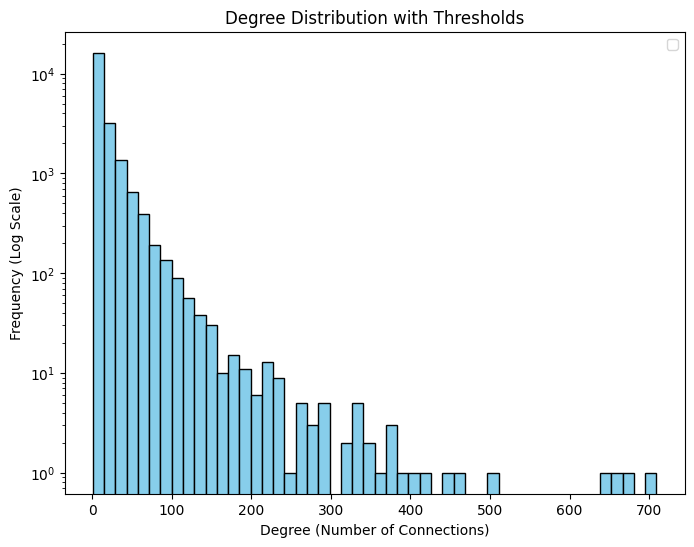

In [8]:
# Compute high and low degree thresholds
high_degree_threshold = degree_series.quantile(0.90)
low_degree_threshold = degree_series.quantile(0.10)

# Plot Degree Histogram
plt.figure(figsize=(8, 6))
plt.hist(degree_series, bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Frequency (Log Scale)")
plt.title("Degree Distribution with Thresholds")
plt.legend()
plt.savefig("degree_thresholds.pdf", dpi=300)
plt.show()


Note: The y-axis uses a logarithmic scale to better visualize the long-tailed distribution of node degrees.


The degree distribution is **highly right-skewed**, which is typical for social networks. Most nodes in the network have a **very low degree**, meaning they are sparsely connected. The majority of nodes have **fewer than 10 connections**, while a small number of nodes serve as **highly connected hubs**.

This structure suggests that the network follows a **scale-free pattern**, where a few central nodes play a key role in connectivity. Such hubs can heavily influence link prediction results and may introduce bias if not handled carefully in training and evaluation phases.

The **vertical dashed lines** indicate the thresholds used to define:
- **High-degree nodes**: Top 10% most connected nodes  
- **Low-degree nodes**: Bottom 10% least connected nodes

These thresholds will be used in further analysis to explore potential **fairness issues** in link prediction models across nodes of different connectivity levels.

In [9]:
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")
print(f"Graph Density: {nx.density(G):.4f}")


Number of Nodes: 22470
Number of Edges: 171002
Graph Density: 0.0007


The network has a total of 22,470 nodes and 171,002 edges. The graph density is approximately 0.0007, indicating that it is extremely sparse — most nodes are not directly connected to one another.


In [10]:
# Check Feature Size
num_nodes = len(features)
num_features = len(next(iter(features.values())))  # First node's features

print(f"Total Nodes in Features: {num_nodes}")
print(f"Each Node has {num_features} Features")

Total Nodes in Features: 22470
Each Node has 22 Features


In [11]:
# Print first node's features
first_node_id = list(features.keys())[0]
print("First node's features:", features[first_node_id])

First node's features: [2835, 4518, 2198, 2014, 3818, 3045, 4570, 4585, 4596, 4599, 4609, 4617, 4627, 4641, 4643, 4651, 4665, 4676, 4682, 4694, 4696, 4708]


In [12]:
# Define High-Degree and Low-Degree Thresholds
high_degree_threshold = degree_series.quantile(0.90)  # Top 10% most connected nodes
low_degree_threshold = degree_series.quantile(0.10)   # Bottom 10% least connected nodes

high_degree_nodes = degree_series[degree_series >= high_degree_threshold].index
low_degree_nodes = degree_series[degree_series <= low_degree_threshold].index

print(f"High-degree Nodes: {len(high_degree_nodes)}")
print(f"Low-degree Nodes: {len(low_degree_nodes)}")


High-degree Nodes: 2328
Low-degree Nodes: 2658


The top 10% of nodes (by degree) represent the most connected Facebook pages in the network, while the bottom 10% represent the least connected. These groups contain 2,328 and 2,658 nodes respectively, allowing for a relatively balanced comparison. This stratification will be useful for evaluating bias in link prediction performance across node connectivity levels.


The top 10% (high-degree nodes) represent the most connected entities, while the bottom 10% (low-degree nodes) show the least connected.The two groups are close in size (2,328 vs. 2,658) - balanced comparison

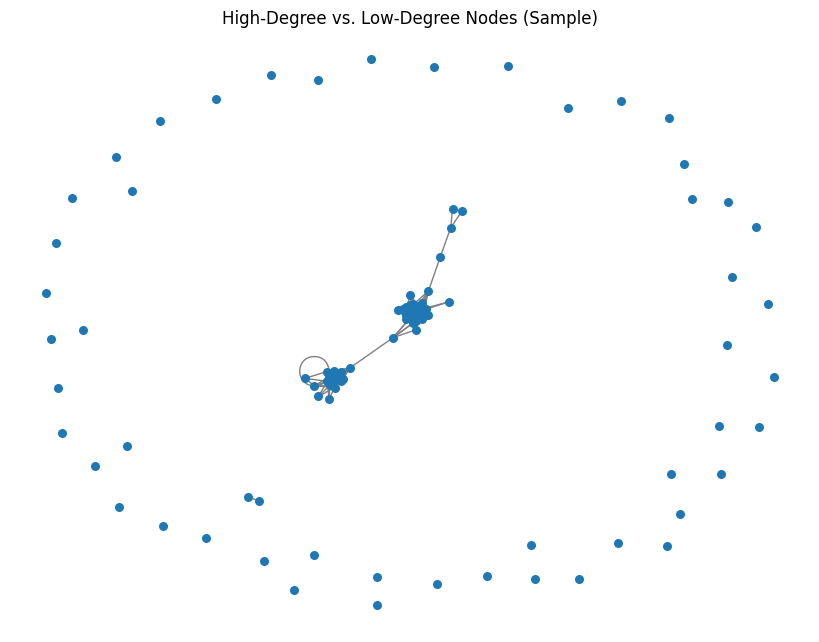

In [13]:
# Subgraph for Visualization
subgraph_nodes = list(high_degree_nodes)[:50] + list(low_degree_nodes)[:50]
subG = G.subgraph(subgraph_nodes)

plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=30, edge_color="gray")
plt.title("High-Degree vs. Low-Degree Nodes (Sample)")
plt.show()


50 high-degree nodes (most connected)
50 low-degree nodes (least connected)

- Densely connected core in the center
- isolated nodes in the peripheral 

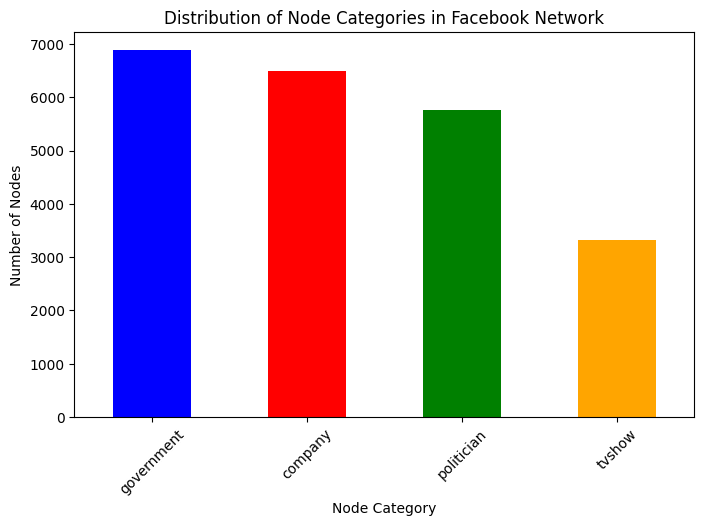

In [14]:
# Load node categories
targets = pd.read_csv("musae_facebook_target.csv")

# Count occurrences of each category
category_counts = targets['page_type'].value_counts()

# Plot Bar Chart
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color=['blue', 'red', 'green', 'orange'])
plt.xlabel("Node Category")
plt.ylabel("Number of Nodes")
plt.title("Distribution of Node Categories in Facebook Network")
plt.xticks(rotation=45)
plt.show()


This bar chart shows the distribution of node categories (types of Facebook pages) in the network:
Government pages (~7,000 nodes) are the most common.
Companies (~6,500 nodes) follow closely.
Politicians (~5,500 nodes) make up a slightly smaller share.
TV Shows (~3,000 nodes) are the least represented.
The network appears to be well-mixed, meaning different page types are spread across the network rather than being isolated in separate clusters.
This suggests that category alone doesn't strictly determine connectivity—pages of different types interact with each other, which is important when evaluating fairness or influence in the graph.

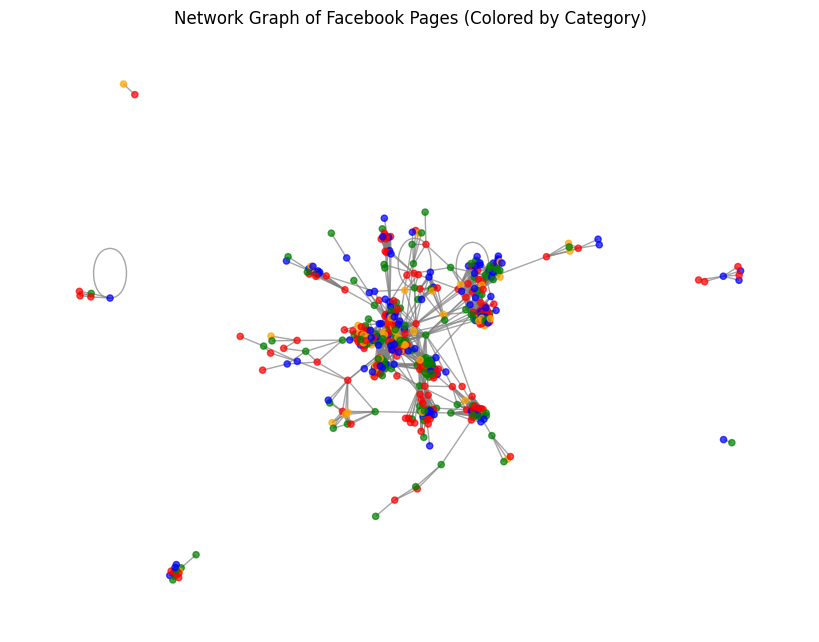

In [15]:
# Create a graph
edges = pd.read_csv("musae_facebook_edges.csv")
G = nx.Graph()
G.add_edges_from(edges.values)

# Define colors for categories
category_colors = {
    "politician": "blue",
    "government": "red",
    "company": "green",
    "tvshow": "orange"
}

# Assign node colors
node_colors = [category_colors.get(cat, "gray") for cat in targets['page_type']]

# Sample a subgraph for visualization (Too large to plot everything)
subG = G.subgraph(list(G.nodes)[:500]) 

plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=20, node_color=node_colors[:500], edge_color="gray", alpha=0.7)
plt.title("Network Graph of Facebook Pages (Colored by Category)")
plt.show()



The network consists of many interconnected clusters, indicating shared interests or mutual relationships between Facebook pages.
Categories appear well-mixed across the graph, suggesting that connections are not strongly driven by category.
Some dense regions form hubs where multiple nodes connect, while other nodes are more isolated or form small groups.

# Full graph experiments

Nodes: 22470, Edges: 171002, Density: 0.000677
Average Clustering Coefficient: 0.359738
Degree Statistics: {'Mean Degree': 15.220471740097908, 'Std Degree': 26.413843606902006, 'Min Degree': 1, 'Max Degree': 709}
Average Shortest Path Length (largest CC): 4.973704
Connected Components: 1
Spearman correlation (degree vs clustering): SignificanceResult(statistic=0.3108147896711387, pvalue=0.0)
Pearson correlation (degree vs clustering): PearsonRResult(statistic=-0.017037711298440207, pvalue=0.010649459060626842)


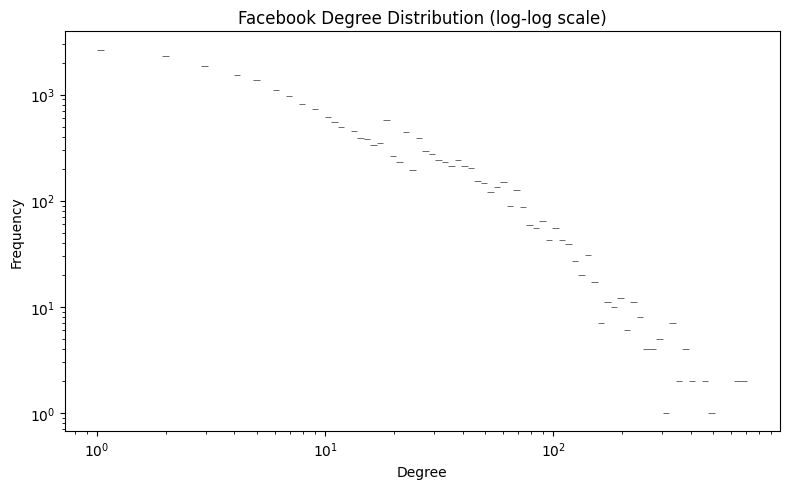

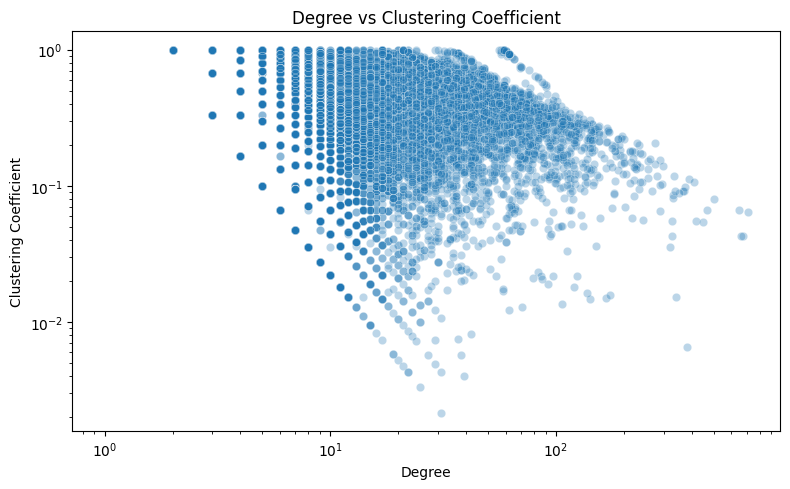

In [ ]:
# Load Facebook edge list
fb_df = pd.read_csv("musae_facebook_edges.csv")  # assumes columns: 'id_1', 'id_2'
fb_df.columns = ['source', 'target']

# Build undirected graph
G = nx.Graph()
for row in fb_df.itertuples(index=False):
    G.add_edge(row.source, row.target)

# 1. Basic stats
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
print(f'Nodes: {num_nodes}, Edges: {num_edges}, Density: {density:.6f}')

# 2. Clustering coefficient
avg_clustering = nx.average_clustering(G)
print(f'Average Clustering Coefficient: {avg_clustering:.6f}')

# 3. Degree statistics
degrees = [deg for _, deg in G.degree()]
degree_stats = {
    "Mean Degree": np.mean(degrees),
    "Std Degree": np.std(degrees),
    "Min Degree": np.min(degrees),
    "Max Degree": np.max(degrees),
}
print("Degree Statistics:", degree_stats)

# 4. Shortest path (largest connected component)
if nx.is_connected(G):
    avg_path_len = nx.average_shortest_path_length(G)
else:
    largest_cc = max(nx.connected_components(G), key=len)
    G_cc = G.subgraph(largest_cc)
    avg_path_len = nx.average_shortest_path_length(G_cc)
print(f'Average Shortest Path Length (largest CC): {avg_path_len:.6f}')

# 5. Connected components
print(f'Connected Components: {nx.number_connected_components(G)}')

# 6. Correlation: Degree vs Clustering
clustering_dict = nx.clustering(G)
clustering_values = [clustering_dict[n] for n in G.nodes()]
degree_values = [G.degree(n) for n in G.nodes()]
df_corr = pd.DataFrame({'degree': degree_values, 'clustering': clustering_values})

spearman_corr = spearmanr(df_corr['degree'], df_corr['clustering'])
pearson_corr = pearsonr(df_corr['degree'], df_corr['clustering'])

print(f"Spearman correlation (degree vs clustering): {spearman_corr}")
print(f"Pearson correlation (degree vs clustering): {pearson_corr}")

# 7. Degree distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(degrees, bins=100, log_scale=(True, True))
plt.title('Facebook Degree Distribution (log-log scale)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 8. Degree vs Clustering scatter
plt.figure(figsize=(8, 5))
sns.scatterplot(x='degree', y='clustering', data=df_corr, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree vs Clustering Coefficient')
plt.xlabel('Degree')
plt.ylabel('Clustering Coefficient')
plt.tight_layout()
plt.show()


# Baseline

In [55]:
# Function for one run
def facebook_baseline():
    # Load edges
    edges = pd.read_csv("musae_facebook_edges.csv")
    src, dst = edges["id_1"].values, edges["id_2"].values

    # Load node features
    with open("musae_facebook_features.json") as f:
        features_dict = json.load(f)

    # Initialize node feature matrix
    num_nodes = len(features_dict)
    feature_dim = max(max(feat_list) for feat_list in features_dict.values()) + 1  
    features = torch.zeros((num_nodes, feature_dim))

    for node, feat_list in features_dict.items():
        features[int(node), feat_list] = 1

    # Build graph and add self-loops
    graph = dgl.graph((src, dst), num_nodes=num_nodes)
    graph = dgl.add_self_loop(graph)

    # Sample negative (non-existent) edges for contrastive training
    def sample_negative_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled_edges = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled_edges.tolist())
        if len(neg_edges) > num_samples:
            neg_edges = neg_edges[:num_samples]
        return torch.tensor(neg_edges, dtype=torch.long)

    # Define GCN encoder
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super(GCNEncoder, self).__init__()
            self.conv1 = GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

        def forward(self, graph, features):
            h = F.relu(self.conv1(graph, features))
            h = self.conv2(graph, h)
            return h
    # Define GCN encoder
    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super(MLPDecoder, self).__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)

        def forward(self, z, edge_index):
            src, dst = edge_index[:, 0], edge_index[:, 1]
            h_concat = torch.cat([z[src], z[dst]], dim=1)
            z = F.elu(self.fc1(h_concat))
            return torch.sigmoid(self.fc2(z)).squeeze()

    # Combine encoder and decoder into a GAE model
    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super(GAE, self).__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)

        def forward(self, graph, features, edges):
            z = self.encoder(graph, features)
            return self.decoder(z, edges)

    # Generate positive and negative edge samples
    positive_edges = torch.tensor(np.column_stack((src, dst)), dtype=torch.long)
    negative_edges = sample_negative_edges(graph, len(positive_edges))

    # Split into train/test sets
    pos_train, pos_test = train_test_split(positive_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(negative_edges, test_size=0.2)

    train_edges = torch.cat([pos_train, neg_train], dim=0)
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])

    test_edges = torch.cat([pos_test, neg_test], dim=0)
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])
    
    # Initialize model and optimizer
    hidden_dim = 128
    out_dim = 32
    model = GAE(feature_dim, hidden_dim, out_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    # Train the model
    epochs = 20
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(graph, features, train_edges)
        loss = loss_fn(output, train_labels)
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_preds = model(graph, features, test_edges).numpy()

    pred_labels = (test_preds > 0.5).astype(int)
    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    # Fairness metrics: Degree-based evaluation
    def fairness_metrics():
        degrees = graph.in_degrees().numpy()
        node_degrees = [min(degrees[u], degrees[v]) for u, v in test_edges.numpy()]
        bins = np.percentile(node_degrees, np.linspace(0, 100, 3))
        bin_indices = np.digitize(node_degrees, bins[1:-1])

        degree_metric = []
        for i in range(2):
            idx = np.where(bin_indices == i)[0]
            if len(idx) == 0: continue
            score = roc_auc_score(test_labels[idx], test_preds[idx])
            degree_metric.append(score)
        degree_gap = max(degree_metric) - min(degree_metric)

         # Demographic parity
        proportions = [np.mean(pred_labels[np.where(bin_indices == i)[0]]) for i in range(2)]
        dp_gap = max(proportions) - min(proportions)

        # Equalized odds
        recalls = []
        for i in range(2):
            idx = np.where(bin_indices == i)[0]
            if len(idx) == 0: continue
            y_true = test_labels[idx]
            y_pred = pred_labels[idx]
            cm = confusion_matrix(y_true, y_pred)
            if cm.size == 4:
                tn, fp, fn, tp = cm.ravel()
                recall = tp / (tp + fn + 1e-8)
            else:
                recall = 0.0
            recalls.append(recall)
        eo_gap = max(recalls) - min(recalls)

        return degree_gap, dp_gap, eo_gap

    degree_gap, dp_gap, eo_gap = fairness_metrics()

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }


# Run 10 times
results = [facebook_baseline() for _ in range(10)]
df = pd.DataFrame(results)
summary = df.agg(['mean', 'std'])
print("\nMetric Means and Standard Deviations:")
print(summary)

# Confidence Intervals (95%)
print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.884622  0.798826   0.793507  0.808970  0.800851    0.004335  0.439648   
std   0.008504  0.005841   0.017048  0.017097  0.003708    0.002011  0.021673   

        EO Gap  
mean  0.232999  
std   0.024953  

95% Confidence Intervals:
AUC: 0.8846 ± 0.0061
Accuracy: 0.7988 ± 0.0042
Precision: 0.7935 ± 0.0122
Recall: 0.8090 ± 0.0122
F1: 0.8009 ± 0.0027
Degree Gap: 0.0043 ± 0.0014
DP Gap: 0.4396 ± 0.0155
EO Gap: 0.2330 ± 0.0179


# FairDrop 

In [56]:
def fairdrop_facebook(drop_prob=0.5):
    # Load edge list
    edges = pd.read_csv("musae_facebook_edges.csv")
    src, dst = edges["id_1"].values, edges["id_2"].values

    # Load node features
    with open("musae_facebook_features.json") as f:
        features_dict = json.load(f)

    num_nodes = len(features_dict)
    feature_dim = max(max(feat_list) for feat_list in features_dict.values()) + 1  
    features = torch.zeros((num_nodes, feature_dim))
    for node, feat_list in features_dict.items():
        features[int(node), feat_list] = 1

    # Build graph and add self-loops
    graph = dgl.graph((src, dst), num_nodes=num_nodes)
    graph = dgl.add_self_loop(graph)

    # Sample negative (non-existent) edges
    def sample_negative_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled_edges = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled_edges.tolist())
        return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

    # Assign sensitive attributes
    degrees = pd.Series(graph.in_degrees().tolist())
    mean_degree = degrees.mean()
    attr = torch.full((graph.num_nodes(),), -1)
    attr[torch.tensor(degrees[degrees <= mean_degree].index)] = 0
    attr[torch.tensor(degrees[degrees > mean_degree].index)] = 1

    # Apply FairDrop: remove edges between same-group nodes
    def apply_fairdrop(graph, sensitive_attr, drop_prob=0.5):
        src, dst = graph.edges()
        src, dst = src.tolist(), dst.tolist()
        edge_mask = []
        for u, v in zip(src, dst):
            if sensitive_attr[u] == sensitive_attr[v] and sensitive_attr[u] != -1:
                keep = np.random.rand() > drop_prob
            else:
                keep = True
            edge_mask.append(keep)
        edge_mask = torch.tensor(edge_mask, dtype=torch.bool)
        new_src = torch.tensor(src)[edge_mask]
        new_dst = torch.tensor(dst)[edge_mask]
        return dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())

    fair_graph = apply_fairdrop(graph, attr, drop_prob)

    # Skip if FairDrop removed all edges
    if fair_graph.num_edges() == 0:
        print("FairDrop produced an empty graph — skipping run.")
        return None

    # Define GCN encoder
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.conv1 = GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

        def forward(self, graph, features):
            h = F.relu(self.conv1(graph, features))
            return self.conv2(graph, h)

    # MLP decoder
    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)

        def forward(self, z, edge_index):
            src, dst = edge_index[:, 0], edge_index[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            z = F.elu(self.fc1(h))
            return torch.sigmoid(self.fc2(z)).squeeze()

    # GAE model
    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)

        def forward(self, graph, features, edges):
            z = self.encoder(graph, features)
            return self.decoder(z, edges)

    # Sample edges
    positive_edges = torch.tensor(np.column_stack((src, dst)), dtype=torch.long)
    negative_edges = sample_negative_edges(graph, len(positive_edges))

    # Skip if no valid edges
    if len(positive_edges) == 0 or len(negative_edges) == 0:
        print("No positive or negative edges — skipping run.")
        return None

    # Train/test split
    pos_train, pos_test = train_test_split(positive_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(negative_edges, test_size=0.2)

    train_edges = torch.cat([pos_train, neg_train], dim=0)
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test], dim=0)
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # Train model
    model = GAE(feature_dim, 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        preds = model(fair_graph, features, train_edges)
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        fair_test_preds = model(fair_graph, features, test_edges).numpy()

    fair_pred_labels = (fair_test_preds > 0.5).astype(int)
    auc = roc_auc_score(test_labels.numpy(), fair_test_preds)
    acc = accuracy_score(test_labels, fair_pred_labels)
    prec = precision_score(test_labels, fair_pred_labels)
    rec = recall_score(test_labels, fair_pred_labels)
    f1 = f1_score(test_labels, fair_pred_labels)

    # Fairness evaluation
    sensitive_attr = attr.numpy()
    src = test_edges[:, 0].numpy()
    dst = test_edges[:, 1].numpy()
    src_group = sensitive_attr[src]
    dst_group = sensitive_attr[dst]
    classified_mask = (src_group != -1) & (dst_group != -1)

    filtered_preds = fair_test_preds[classified_mask]
    filtered_labels = test_labels[classified_mask]
    group_0_mask = (src_group[classified_mask] == 0) & (dst_group[classified_mask] == 0)
    group_1_mask = (src_group[classified_mask] == 1) & (dst_group[classified_mask] == 1)

    if group_0_mask.sum() > 0 and group_1_mask.sum() > 0:
        auc_0 = roc_auc_score(filtered_labels[group_0_mask], filtered_preds[group_0_mask])
        auc_1 = roc_auc_score(filtered_labels[group_1_mask], filtered_preds[group_1_mask])
        degree_gap = abs(auc_0 - auc_1)
    else:
        degree_gap = 0

    pred_binary = (filtered_preds > 0.5).astype(int)
    dp_0 = pred_binary[group_0_mask].mean() if group_0_mask.sum() > 0 else 0
    dp_1 = pred_binary[group_1_mask].mean() if group_1_mask.sum() > 0 else 0
    dp_gap = abs(dp_0 - dp_1)

    recall_0 = recall_score(filtered_labels[group_0_mask], pred_binary[group_0_mask]) if group_0_mask.sum() > 0 else 0
    recall_1 = recall_score(filtered_labels[group_1_mask], pred_binary[group_1_mask]) if group_1_mask.sum() > 0 else 0
    eo_gap = abs(recall_0 - recall_1)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# Run 10 times and skip invalid runs
raw_results = [fairdrop_facebook() for _ in range(10)]
fairdrop_results = [r for r in raw_results if r is not None]
fairdrop_df = pd.DataFrame(fairdrop_results)
fairdrop_summary = fairdrop_df.agg(['mean', 'std'])

print("FairDrop Metrics Summary (Mean & Std):")
print(fairdrop_summary)

print("\n95% Confidence Intervals:")
for col in fairdrop_df.columns:
    mean = fairdrop_df[col].mean()
    std_err = st.sem(fairdrop_df[col])
    ci = st.t.interval(0.95, len(fairdrop_df[col]) - 1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


FairDrop Metrics Summary (Mean & Std):
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.868960  0.782110   0.780672  0.786705  0.782883    0.101225  0.794874   
std   0.003873  0.002292   0.019893  0.032693  0.008067    0.003967  0.014174   

        EO Gap  
mean  0.741887  
std   0.040055  

95% Confidence Intervals:
AUC: 0.8690 ± 0.0028
Accuracy: 0.7821 ± 0.0016
Precision: 0.7807 ± 0.0142
Recall: 0.7867 ± 0.0234
F1: 0.7829 ± 0.0058
Degree Gap: 0.1012 ± 0.0028
DP Gap: 0.7949 ± 0.0101
EO Gap: 0.7419 ± 0.0287


# FairWalk 

In [ ]:
def fairwalk_facebook(walk_length=20, num_walks=3):
    # Load full graph
    edges_df = pd.read_csv("musae_facebook_edges.csv")
    graph = nx.from_pandas_edgelist(edges_df, source="id_1", target="id_2")
    nodes = list(graph.nodes())

    # Sensitive attribute: high vs low degree
    degrees = np.array([graph.degree(n) for n in nodes])
    mean_deg = degrees.mean()
    sensitive_attr = {node: 0 if graph.degree(node) <= mean_deg else 1 for node in nodes}

    # FairWalks over full graph
    def generate_fairwalks(graph, attr_dict, num_walks, walk_length):
        walks = []
        nodes = list(graph.nodes())
        for _ in range(num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walk = [node]
                while len(walk) < walk_length:
                    curr = walk[-1]
                    neighbors = list(graph.neighbors(curr))
                    if not neighbors:
                        break
                    opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                    next_node = random.choice(opp_group if opp_group else neighbors)
                    walk.append(next_node)
                walks.append([str(n) for n in walk])
        return walks

    walks = generate_fairwalks(graph, sensitive_attr, num_walks=num_walks, walk_length=walk_length)
    model = Word2Vec(walks, vector_size=32, window=3, min_count=1, sg=1, workers=4, epochs=5)
    embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}

    # Create all positive edges (real)
    pos_edges = list(graph.edges())
    
    # Create negative edges (non-existing edges)
    neg_edges = []
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(nodes, 2)
        if not graph.has_edge(u, v):
            neg_edges.append((u, v))

    # Combine and shuffle
    all_pairs = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)
    all_pairs, labels = shuffle(all_pairs, labels)
    train_pairs, test_pairs, y_train, y_test = train_test_split(all_pairs, labels, test_size=0.2)

    # Feature construction using Hadamard product
    def make_features(pairs, label):
        X, y, kept = [], [], []
        for u, v in pairs:
            if u in embeddings and v in embeddings:
                X.append(embeddings[u] * embeddings[v])
                y.append(label)
                kept.append((u, v))
        return X, y, kept

    X_pos, y_pos, _ = make_features([p for p, l in zip(train_pairs, y_train) if l == 1], 1)
    X_neg, y_neg, _ = make_features([p for p, l in zip(train_pairs, y_train) if l == 0], 0)
    X_train = np.array(X_pos + X_neg)
    y_train = np.array(y_pos + y_neg)

    X_pos, y_pos, pos_test = make_features([p for p, l in zip(test_pairs, y_test) if l == 1], 1)
    X_neg, y_neg, neg_test = make_features([p for p, l in zip(test_pairs, y_test) if l == 0], 0)
    X_test = np.array(X_pos + X_neg)
    y_test = np.array(y_pos + y_neg)
    test_edges = pos_test + neg_test

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=0.05, penalty='l2')
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    # Evaluation metrics
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness metrics
    edge_deg = [max(sensitive_attr.get(u, 0), sensitive_attr.get(v, 0)) for u, v in test_edges]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    degree_gap = abs(y_proba[high_mask].mean() - y_proba[low_mask].mean())
    dp_gap = abs(y_pred[high_mask].mean() - y_pred[low_mask].mean())

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8)

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8)
    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": degree_gap, "DP Gap": dp_gap, "EO Gap": eo_gap
    }
# Run 10x 
fairwalk_results = [fairwalk_facebook() for _ in range(10)]
fairwalk_df = pd.DataFrame(fairwalk_results)
fairwalk_summary = fairwalk_df.agg(['mean', 'std'])

print("\nFairWalk Full Graph Summary (Mean & Std):")
print(fairwalk_summary)

print("\n95% Confidence Intervals:")
for col in fairwalk_df.columns:
    mean = fairwalk_df[col].mean()
    std_err = st.sem(fairwalk_df[col])
    ci = st.t.interval(0.95, len(fairwalk_df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



FairWalk Full Graph Summary (Mean & Std):
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.911638  0.832428   0.884382  0.765097  0.820419    0.303598  0.386026   
std   0.008404  0.006709   0.005811  0.008699  0.007320    0.010054  0.007899   

        EO Gap  
mean  0.203894  
std   0.012587  

95% Confidence Intervals:
AUC: 0.9116 ± 0.0060
Accuracy: 0.8324 ± 0.0048
Precision: 0.8844 ± 0.0042
Recall: 0.7651 ± 0.0062
F1: 0.8204 ± 0.0052
Degree Gap: 0.3036 ± 0.0072
DP Gap: 0.3860 ± 0.0057
EO Gap: 0.2039 ± 0.0090


# FairAdj

In [59]:
def fairadj_facebook():
    # Load full Facebook graph
    df = pd.read_csv("musae_facebook_edges.csv")
    G = nx.from_pandas_edgelist(df, source="id_1", target="id_2")

    # Sensitive attribute: based on degree centrality
    degree_dict = nx.degree_centrality(G)
    mean_deg = np.mean(list(degree_dict.values()))
    sensitive_attr = {n: int(degree_dict[n] >= mean_deg) for n in G.nodes()}

    # Convert edges to torch format
    edge_index = torch.tensor(list(G.edges())).T

    # FairAdj: drop edges between same-group nodes with probability
    def apply_fairadj(edge_index, sensitive_attr, drop_rate=0.5):
        src, dst = edge_index
        mask = []
        for u, v in zip(src.tolist(), dst.tolist()):
            same_group = sensitive_attr[u] == sensitive_attr[v]
            drop = same_group and np.random.rand() < drop_rate
            mask.append(not drop)
        mask_tensor = torch.tensor(mask, dtype=torch.bool)
        return torch.stack([src[mask_tensor], dst[mask_tensor]])

    # Apply FairAdj globally to full graph
    fair_edge_index = apply_fairadj(edge_index, sensitive_attr)
    fair_graph = nx.from_edgelist(fair_edge_index.numpy().T)

    # Generate equal number of negative edges
    pos_edges = list(fair_graph.edges())
    all_nodes = list(fair_graph.nodes())
    neg_edges = []
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(all_nodes, 2)
        if not fair_graph.has_edge(u, v) and u != v:
            neg_edges.append((u, v))

    # Shuffle and split
    edges = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)
    edges, labels = shuffle(edges, labels)
    train_edges, test_edges, y_train, y_test = train_test_split(edges, labels, test_size=0.2)

    # Train Node2Vec on the **full FairAdj graph**
    n2v = Node2Vec(fair_graph, dimensions=32, walk_length=20, num_walks=3, workers=4)
    model = n2v.fit(window=5, min_count=1, batch_words=4, epochs=5)
    emb_dict = {str(node): model.wv[str(node)] for node in fair_graph.nodes()}

    # Filter only edges with embeddings
    def filter_edges(edge_list, label_list):
        filtered, filtered_labels = [], []
        for (u, v), lbl in zip(edge_list, label_list):
            if str(u) in emb_dict and str(v) in emb_dict:
                filtered.append((u, v))
                filtered_labels.append(lbl)
        return filtered, filtered_labels

    train_edges, y_train = filter_edges(train_edges, y_train)
    test_edges, y_test = filter_edges(test_edges, y_test)

    # Embed edges
    def embed_edges(edge_list, label_list):
        X, y = [], []
        for (u, v), lbl in zip(edge_list, label_list):
            X.append(np.concatenate([emb_dict[str(u)], emb_dict[str(v)]]))
            y.append(lbl)
        return np.array(X), np.array(y)

    X_train, y_train = embed_edges(train_edges, y_train)
    X_test, y_test = embed_edges(test_edges, y_test)

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=0.001)
    clf.fit(X_train, y_train)
    y_probs = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    # Metrics
    auc = roc_auc_score(y_test, y_probs)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness metrics
    def compute_degree_fairness():
        groups = {0: [], 1: []}
        for (u, v), prob in zip(test_edges, y_probs):
            if sensitive_attr.get(u) == sensitive_attr.get(v):
                groups[sensitive_attr[u]].append(prob)
        return abs(np.mean(groups[0]) - np.mean(groups[1])) if groups[0] and groups[1] else 0

    def demographic_parity():
        g0 = [p for (u, _), p in zip(test_edges, y_pred) if sensitive_attr.get(u) == 0]
        g1 = [p for (u, _), p in zip(test_edges, y_pred) if sensitive_attr.get(u) == 1]
        return abs(np.mean(g0) - np.mean(g1)) if g0 and g1 else 0

    def equalized_odds():
        g0 = [(yt, yp) for (u, _), yt, yp in zip(test_edges, y_test, y_pred) if sensitive_attr.get(u) == 0]
        g1 = [(yt, yp) for (u, _), yt, yp in zip(test_edges, y_test, y_pred) if sensitive_attr.get(u) == 1]
        def tpr(g): return sum(yt == yp == 1 for yt, yp in g) / sum(yt == 1 for yt, _ in g) if any(yt == 1 for yt, _ in g) else 0
        return abs(tpr(g0) - tpr(g1))

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": compute_degree_fairness(),
        "DP Gap": demographic_parity(),
        "EO Gap": equalized_odds()
    }

# Run 10 times for summary
results = [fairadj_facebook() for _ in range(10)]
df = pd.DataFrame(results)
print("FairAdj Full Graph Metrics Summary (Mean & Std):")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 

FairAdj Full Graph Metrics Summary (Mean & Std):
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.811839  0.736106   0.726427  0.757982  0.741859    0.448328  0.579617   
std   0.002065  0.002132   0.003196  0.004197  0.002354    0.010342  0.010587   

        EO Gap  
mean  0.421408  
std   0.017180  

95% Confidence Intervals:
AUC: 0.8118 ± 0.0015
Accuracy: 0.7361 ± 0.0015
Precision: 0.7264 ± 0.0023
Recall: 0.7580 ± 0.0030
F1: 0.7419 ± 0.0017
Degree Gap: 0.4483 ± 0.0074
DP Gap: 0.5796 ± 0.0076
EO Gap: 0.4214 ± 0.0123


# Subgraph experiments



In [17]:
def sample_extreme_degree_nodes(G, num_samples=10, subset_size=10000):

    degrees = dict(G.degree())
    nodes_sorted = sorted(degrees.items(), key=lambda x: x[1])

    best_high_subset = []
    best_high_avg = -np.inf

    best_low_subset = []
    best_low_avg = np.inf

    for _ in range(num_samples):
        # Sample high-degree candidates from top 50% of degrees
        top_half_nodes = [n for n, d in nodes_sorted[int(len(nodes_sorted)/2):]]
        high_subset = random.sample(top_half_nodes, subset_size)
        high_avg = np.mean([degrees[n] for n in high_subset])
        if high_avg > best_high_avg:
            best_high_avg = high_avg
            best_high_subset = high_subset

        # Sample low-degree candidates from bottom 50% of degrees
        bottom_half_nodes = [n for n, d in nodes_sorted[:int(len(nodes_sorted)/2)]]
        low_subset = random.sample(bottom_half_nodes, subset_size)
        low_avg = np.mean([degrees[n] for n in low_subset])
        if low_avg < best_low_avg:
            best_low_avg = low_avg
            best_low_subset = low_subset

    print(f"Selected high-degree avg: {best_high_avg:.2f}, low-degree avg: {best_low_avg:.2f}")
    return best_high_subset, best_low_subset


In [18]:
# G is NetworkX graph
high_nodes, low_nodes = sample_extreme_degree_nodes(G)

# Save them for reuse
with open('high_degree_nodes.txt', 'w') as f:
    for node in high_nodes:
        f.write(f"{node}\n")

with open('low_degree_nodes.txt', 'w') as f:
    for node in low_nodes:
        f.write(f"{node}\n")


Selected high-degree avg: 27.41, low-degree avg: 3.14



===== Facebook High-Degree Subgraph =====
Nodes: 10000, Edges: 112616, Density: 0.002253
Average Clustering Coefficient: 0.442507
Degree Statistics: {'Mean Degree': 22.5232, 'Std Degree': 29.23487406779786, 'Min Degree': 0, 'Max Degree': 618}
Average Shortest Path Length (largest CC): 4.141732
Connected Components: 23
Spearman correlation (degree vs clustering): SignificanceResult(statistic=-0.07324081511515304, pvalue=2.2503101186184993e-13)
Pearson correlation (degree vs clustering): PearsonRResult(statistic=-0.1751249882383773, pvalue=1.0760559889386494e-69)


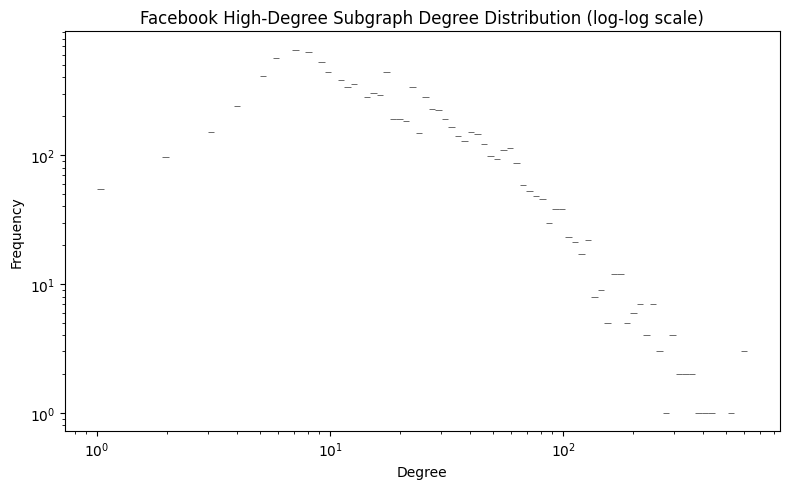

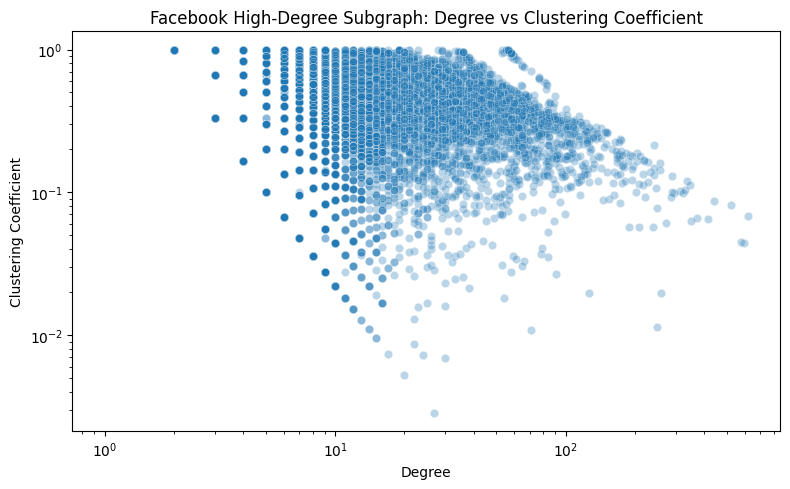


===== Facebook Low-Degree Subgraph =====
Nodes: 10000, Edges: 4240, Density: 0.000085
Average Clustering Coefficient: 0.061576
Degree Statistics: {'Mean Degree': 0.848, 'Std Degree': 1.0842951627670394, 'Min Degree': 0, 'Max Degree': 7}
Average Shortest Path Length (largest CC): 9.573399
Connected Components: 6311
Spearman correlation (degree vs clustering): SignificanceResult(statistic=0.4659015898750977, pvalue=0.0)
Pearson correlation (degree vs clustering): PearsonRResult(statistic=0.46621772616193446, pvalue=0.0)


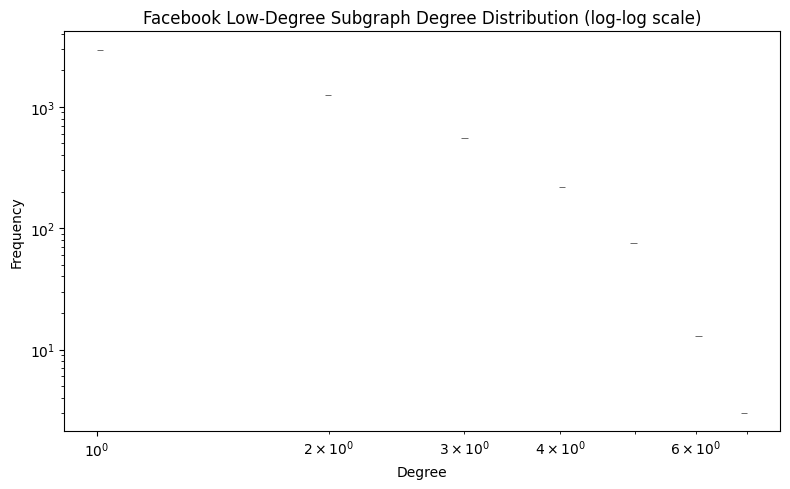

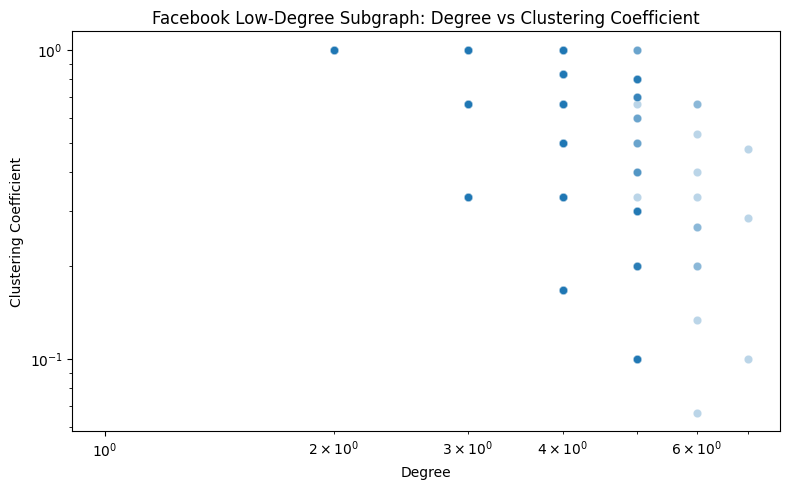

In [ ]:
# Load edge list and construct full graph
fb_df = pd.read_csv("musae_facebook_edges.csv")
fb_df.columns = ['source', 'target']
G = nx.Graph()
for row in fb_df.itertuples(index=False):
    G.add_edge(row.source, row.target)

# Load sampled high- and low-degree nodes 
with open('high_degree_nodes.txt', 'r') as f:
    high_nodes = [int(line.strip()) for line in f.readlines()]

with open('low_degree_nodes.txt', 'r') as f:
    low_nodes = [int(line.strip()) for line in f.readlines()]

# Build subgraphs
G_high = G.subgraph(high_nodes).copy()
G_low = G.subgraph(low_nodes).copy()

# Function to analyze and plot stats
def analyze_graph_stats(G, name="Graph"):
    print(f"\n===== {name} =====")
    
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    print(f'Nodes: {num_nodes}, Edges: {num_edges}, Density: {density:.6f}')
    
    avg_clustering = nx.average_clustering(G)
    print(f'Average Clustering Coefficient: {avg_clustering:.6f}')
    
    degrees = [deg for _, deg in G.degree()]
    degree_stats = {
        "Mean Degree": np.mean(degrees),
        "Std Degree": np.std(degrees),
        "Min Degree": np.min(degrees),
        "Max Degree": np.max(degrees),
    }
    print("Degree Statistics:", degree_stats)

    if nx.is_connected(G):
        avg_path_len = nx.average_shortest_path_length(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        G_cc = G.subgraph(largest_cc)
        avg_path_len = nx.average_shortest_path_length(G_cc)
    print(f'Average Shortest Path Length (largest CC): {avg_path_len:.6f}')
    
    print(f'Connected Components: {nx.number_connected_components(G)}')
    
    clustering_dict = nx.clustering(G)
    clustering_values = [clustering_dict[n] for n in G.nodes()]
    degree_values = [G.degree(n) for n in G.nodes()]
    df_corr = pd.DataFrame({'degree': degree_values, 'clustering': clustering_values})

    spearman_corr = spearmanr(df_corr['degree'], df_corr['clustering'])
    pearson_corr = pearsonr(df_corr['degree'], df_corr['clustering'])

    print(f"Spearman correlation (degree vs clustering): {spearman_corr}")
    print(f"Pearson correlation (degree vs clustering): {pearson_corr}")

    # Degree distribution plot
    plt.figure(figsize=(8, 5))
    sns.histplot(degree_values, bins=100, log_scale=(True, True))
    plt.title(f'{name} Degree Distribution (log-log scale)')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Degree vs Clustering scatter
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='degree', y='clustering', data=df_corr, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{name}: Degree vs Clustering Coefficient')
    plt.xlabel('Degree')
    plt.ylabel('Clustering Coefficient')
    plt.tight_layout()
    plt.show()

# Run 
analyze_graph_stats(G_high, name="Facebook High-Degree Subgraph")
analyze_graph_stats(G_low, name="Facebook Low-Degree Subgraph")


# Baseline

## Low degree nodes 

In [19]:
def facebook_low_degree_ego_baseline():
    # Load edges
    edges = pd.read_csv("musae_facebook_edges.csv")
    src, dst = edges["id_1"].values, edges["id_2"].values

    # Build NetworkX graph to extract ego networks
    G_nx = nx.Graph()
    G_nx.add_edges_from(zip(src, dst))

    # Load precomputed low-degree nodes from file
    with open("low_degree_nodes.txt", "r") as f:
        low_degree_nodes = [int(line.strip()) for line in f.readlines()]


    # Build union of 1-hop ego networks
    all_nodes = set()
    for node in low_degree_nodes:
        ego = nx.ego_graph(G_nx, node, radius=1)
        all_nodes.update(ego.nodes())

    # Induce subgraph
    subgraph_nx = G_nx.subgraph(all_nodes).copy()
    if subgraph_nx.number_of_edges() == 0:
        return None

    # Reindex nodes
    node_list = list(subgraph_nx.nodes())
    node_mapping = {node: i for i, node in enumerate(node_list)}
    sub_src = [node_mapping[u] for u, v in subgraph_nx.edges()]
    sub_dst = [node_mapping[v] for u, v in subgraph_nx.edges()]
    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(node_list))
    sub_graph = dgl.add_self_loop(sub_graph)

    # Load and filter features
    with open("musae_facebook_features.json") as f:
        features_dict = json.load(f)

    # Convert keys to int
    features_dict = {int(k): v for k, v in features_dict.items()}
    feature_dim = max(max(feats) for feats in features_dict.values()) + 1
    max_node_id = max(features_dict.keys())
    features = torch.zeros((max_node_id + 1, feature_dim))
    for node, feats in features_dict.items():
        features[node, feats] = 1

    sub_features = features[torch.tensor(node_list)]

    # Positive and negative edges
    pos_edges = torch.tensor(list(zip(sub_src, sub_dst)), dtype=torch.long)
    if len(pos_edges) == 0:
        return None

    def sample_negative_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

    neg_edges = sample_negative_edges(sub_graph, len(pos_edges))

    # Train-test split
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)

    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # Define GAE model
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.conv1 = GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)
        def forward(self, g, x):
            x = F.relu(self.conv1(g, x))
            return self.conv2(g, x)

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)
        def forward(self, z, edge_index):
            src, dst = edge_index[:, 0], edge_index[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)
        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    # Train model
    model = GAE(sub_features.shape[1], 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    for epoch in range(20):
        model.train()
        optimizer.zero_grad()
        pred = model(sub_graph, sub_features, train_edges)
        loss = loss_fn(pred, train_labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        test_preds = model(sub_graph, sub_features, test_edges).numpy()

    pred_labels = (test_preds > 0.5).astype(int)
    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    # Fairness metrics
    node_deg = sub_graph.in_degrees().numpy()
    edge_deg = [min(node_deg[u], node_deg[v]) for u, v in test_edges.numpy()]
    threshold = np.mean(edge_deg)
    bin_idx = np.array([0 if d <= threshold else 1 for d in edge_deg])

    degree_scores, proportions, recalls = [], [], []
    for i in range(2):
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0:
            continue
        y_true = test_labels[idx]
        y_pred = pred_labels[idx]
        y_prob = test_preds[idx]

        if len(np.unique(y_true)) > 1:
            degree_scores.append(roc_auc_score(y_true, y_prob))
        proportions.append(np.mean(y_pred))

        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    degree_gap = max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else 0.0
    dp_gap = max(proportions) - min(proportions) if len(proportions) >= 2 else 0.0
    eo_gap = max(recalls) - min(recalls) if len(recalls) >= 2 else 0.0

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": degree_gap, "DP Gap": dp_gap, "EO Gap": eo_gap
    }


# 10 runs
results = [facebook_low_degree_ego_baseline() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.860628  0.774582   0.758766  0.807421  0.781603    0.006927  0.444245   
std   0.004726  0.003605   0.018686  0.032806  0.005312    0.004912  0.015431   

        EO Gap  
mean  0.216099  
std   0.023052  

95% Confidence Intervals:
AUC: 0.8606 ± 0.0034
Accuracy: 0.7746 ± 0.0026
Precision: 0.7588 ± 0.0134
Recall: 0.8074 ± 0.0235
F1: 0.7816 ± 0.0038
Degree Gap: 0.0069 ± 0.0035
DP Gap: 0.4442 ± 0.0110
EO Gap: 0.2161 ± 0.0165


## High degree nodes 

In [24]:
def facebook_high_degree_ego_baseline():
    # Load edges and build full graph
    edges = pd.read_csv("musae_facebook_edges.csv")
    src, dst = edges["id_1"].values, edges["id_2"].values
    full_graph = dgl.graph((src, dst))
    degrees = full_graph.in_degrees().numpy()
    node_ids = np.arange(full_graph.num_nodes())

    # Load precomputed high-degree nodes from file
    with open("high_degree_nodes.txt", "r") as f:
        high_degree_nodes = [int(line.strip()) for line in f.readlines()]

    # k=1 ego graph: include neighbors and edges among them
    ego_nodes = set(high_degree_nodes)
    for node in high_degree_nodes:
        ego_nodes.update(full_graph.successors(node).numpy())
        ego_nodes.update(full_graph.predecessors(node).numpy())
    ego_nodes = np.array(sorted(ego_nodes))

    # Mask for subgraph
    mask = np.isin(src, ego_nodes) & np.isin(dst, ego_nodes)
    sub_edges = edges[mask]
    sub_src, sub_dst = sub_edges["id_1"].values, sub_edges["id_2"].values

    # Load node features
    with open("musae_facebook_features.json") as f:
        features_dict = json.load(f)
    feature_dim = max(max(f) for f in features_dict.values()) + 1
    features = torch.zeros((len(features_dict), feature_dim))
    for node, feats in features_dict.items():
        features[int(node), feats] = 1
    sub_features = features[ego_nodes]

    # Reindex subgraph
    node_map = {old: new for new, old in enumerate(ego_nodes)}
    sub_src = np.array([node_map[s] for s in sub_src])
    sub_dst = np.array([node_map[d] for d in sub_dst])
    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(ego_nodes))
    sub_graph = dgl.add_self_loop(sub_graph)

    # Sample negative edges
    def sample_negative_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.conv1 = GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

        def forward(self, g, x):
            return self.conv2(g, F.relu(self.conv1(g, x)))

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)

        def forward(self, z, edge_index):
            src, dst = edge_index[:, 0], edge_index[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)

        def forward(self, g, x, edges):
            z = self.encoder(g, x)
            return self.decoder(z, edges)

    # Create edges
    pos_edges = torch.tensor(np.column_stack((sub_src, sub_dst)), dtype=torch.long)
    neg_edges = sample_negative_edges(sub_graph, len(pos_edges))

    # Train-test split
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)

    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # Train GAE
    model = GAE(sub_features.shape[1], 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    for epoch in range(20):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(model(sub_graph, sub_features, train_edges), train_labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_preds = model(sub_graph, sub_features, test_edges).numpy()

    pred_labels = (test_preds > 0.5).astype(int)
    auc = roc_auc_score(test_labels, test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    # Fairness metrics
    node_deg = sub_graph.in_degrees().numpy()
    edge_deg = [min(node_deg[u], node_deg[v]) for u, v in test_edges.numpy()]
    threshold = np.mean(edge_deg)
    bin_idx = np.array([0 if d <= threshold else 1 for d in edge_deg])

    degree_scores, proportions, recalls = [], [], []
    for i in range(2):
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0:
            continue
        y_true, y_pred, y_prob = test_labels[idx], pred_labels[idx], test_preds[idx]
        if len(np.unique(y_true)) > 1:
            degree_scores.append(roc_auc_score(y_true, y_prob))
        proportions.append(np.mean(y_pred))
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    degree_gap = max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else 0.0
    dp_gap = max(proportions) - min(proportions) if len(proportions) >= 2 else 0.0
    eo_gap = max(recalls) - min(recalls) if len(recalls) >= 2 else 0.0

    return {
        "AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Degree Gap": degree_gap, "DP Gap": dp_gap, "EO Gap": eo_gap
    }

# Run and evaluate 10 times
results = [facebook_high_degree_ego_baseline() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.878895  0.789854   0.776161  0.814897  0.794981    0.010888  0.508901   
std   0.005369  0.004116   0.007970  0.010228  0.003839    0.003451  0.014734   

        EO Gap  
mean  0.250790  
std   0.014169  

95% Confidence Intervals:
AUC: 0.8789 ± 0.0038
Accuracy: 0.7899 ± 0.0029
Precision: 0.7762 ± 0.0057
Recall: 0.8149 ± 0.0073
F1: 0.7950 ± 0.0027
Degree Gap: 0.0109 ± 0.0025
DP Gap: 0.5089 ± 0.0105
EO Gap: 0.2508 ± 0.0101


# FairDrop 

## Low degree nodes 


In [23]:
def facebook_low_degree_ego_fairdrop(drop_prob=0.5):
    # Load edge list and graph
    edges = pd.read_csv("musae_facebook_edges.csv")
    src, dst = edges["id_1"].values, edges["id_2"].values
    graph = dgl.graph((src, dst))
    degrees = graph.in_degrees().numpy()
    node_ids = np.arange(graph.num_nodes())

    # Load precomputed low-degree nodes from file
    with open("low_degree_nodes.txt", "r") as f:
        low_degree_nodes = [int(line.strip()) for line in f.readlines()]

    # Build 1-hop ego network
    ego_nodes = set(low_degree_nodes)
    for node in low_degree_nodes:
        ego_nodes.update(graph.successors(node).numpy())
        ego_nodes.update(graph.predecessors(node).numpy())
    ego_nodes = np.array(sorted(ego_nodes))

    # Mask for subgraph edges
    mask = np.isin(src, ego_nodes) & np.isin(dst, ego_nodes)
    sub_edges = edges[mask]
    sub_src, sub_dst = sub_edges["id_1"].values, sub_edges["id_2"].values

    # Load node features
    with open("musae_facebook_features.json") as f:
        features_dict = json.load(f)

    feature_dim = max(max(f) for f in features_dict.values()) + 1
    features = torch.zeros((len(features_dict), feature_dim))
    for node, feats in features_dict.items():
        features[int(node), feats] = 1
    sub_features = features[ego_nodes]

    # Reindex subgraph
    node_map = {old: new for new, old in enumerate(ego_nodes)}
    sub_src = np.array([node_map[s] for s in sub_src])
    sub_dst = np.array([node_map[d] for d in sub_dst])
    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(ego_nodes))
    sub_graph = dgl.add_self_loop(sub_graph)

    # Assign sensitive attribute by degree
    sub_degrees = sub_graph.in_degrees().numpy()
    mean_deg = sub_degrees.mean()
    attr = torch.zeros(len(ego_nodes), dtype=torch.long)
    attr[sub_degrees > mean_deg] = 1

    # FairDrop function
    def apply_fairdrop(graph, sensitive_attr, drop_prob):
        src, dst = graph.edges()
        src, dst = src.tolist(), dst.tolist()
        edge_mask = []
        for u, v in zip(src, dst):
            if sensitive_attr[u] == sensitive_attr[v]:
                keep = np.random.rand() > drop_prob
            else:
                keep = True
            edge_mask.append(keep)
        edge_mask = torch.tensor(edge_mask, dtype=torch.bool)
        new_src = torch.tensor(src)[edge_mask]
        new_dst = torch.tensor(dst)[edge_mask]
        return dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())

    fair_graph = apply_fairdrop(sub_graph, attr, drop_prob)
    fair_graph = dgl.add_self_loop(fair_graph)

    # GAE model components
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.conv1 = GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

        def forward(self, g, x):
            return self.conv2(g, F.relu(self.conv1(g, x)))

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)

        def forward(self, z, edge_index):
            h = torch.cat([z[edge_index[:, 0]], z[edge_index[:, 1]]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)

        def forward(self, g, x, edge_index):
            z = self.encoder(g, x)
            return self.decoder(z, edge_index)

    # Negative edge sampling
    def sample_negative_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

    pos_edges = torch.tensor(np.column_stack((sub_src, sub_dst)), dtype=torch.long)
    neg_edges = sample_negative_edges(sub_graph, len(pos_edges))

    # Train-test split
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # Training loop
    model = GAE(sub_features.shape[1], 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        pred = model(fair_graph, sub_features, train_edges)
        loss = loss_fn(pred, train_labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        preds = model(fair_graph, sub_features, test_edges).numpy()

    pred_labels = (preds > 0.5).astype(int)
    auc = roc_auc_score(test_labels.numpy(), preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    # Fairness evaluation
    degs = sub_graph.in_degrees().numpy()
    edge_degs = [min(degs[u], degs[v]) for u, v in test_edges.numpy()]
    threshold = np.mean(edge_degs)
    bin_idx = np.array([0 if d <= threshold else 1 for d in edge_degs])

    degree_scores, proportions, recalls = [], [], []
    for i in range(2):
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0:
            continue
        y_true = test_labels[idx]
        y_pred = pred_labels[idx]
        y_prob = preds[idx]
        if len(np.unique(y_true)) > 1:
            degree_scores.append(roc_auc_score(y_true, y_prob))
        proportions.append(np.mean(y_pred))
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    degree_gap = max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else 0.0
    dp_gap = max(proportions) - min(proportions) if len(proportions) >= 2 else 0.0
    eo_gap = max(recalls) - min(recalls) if len(recalls) >= 2 else 0.0

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# Run 10 times
results = [facebook_low_degree_ego_fairdrop() for _ in range(10)]
df = pd.DataFrame(results)

# Print summary
print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.857874  0.775226   0.767378  0.792446  0.778805    0.026513  0.426328   
std   0.003780  0.003498   0.020776  0.035732  0.007693    0.006454  0.011978   

        EO Gap  
mean  0.178284  
std   0.012253  

95% Confidence Intervals:
AUC: 0.8579 ± 0.0027
Accuracy: 0.7752 ± 0.0025
Precision: 0.7674 ± 0.0149
Recall: 0.7924 ± 0.0256
F1: 0.7788 ± 0.0055
Degree Gap: 0.0265 ± 0.0046
DP Gap: 0.4263 ± 0.0086
EO Gap: 0.1783 ± 0.0088


## High degree nodes 


In [25]:
def facebook_high_degree_ego_fairdrop(drop_prob=0.5):
    # Load edge list and full graph
    edges = pd.read_csv("musae_facebook_edges.csv")
    src, dst = edges["id_1"].values, edges["id_2"].values
    full_graph = dgl.graph((src, dst))
    degrees = full_graph.in_degrees().numpy()

    # Load precomputed high-degree nodes
    with open("high_degree_nodes.txt", "r") as f:
        high_degree_nodes = [int(line.strip()) for line in f.readlines()]

    # Build 1-hop ego network
    ego_nodes = set(high_degree_nodes)
    for node in high_degree_nodes:
        ego_nodes.update(full_graph.successors(node).numpy())
        ego_nodes.update(full_graph.predecessors(node).numpy())
    ego_nodes = np.array(sorted(ego_nodes))

    # Filter edges within ego subgraph
    mask = np.isin(src, ego_nodes) & np.isin(dst, ego_nodes)
    sub_edges = edges[mask]
    sub_src = sub_edges["id_1"].values
    sub_dst = sub_edges["id_2"].values

    # Load and subset node features
    with open("musae_facebook_features.json") as f:
        features_dict = json.load(f)
    feature_dim = max(max(f) for f in features_dict.values()) + 1
    features = torch.zeros((len(features_dict), feature_dim))
    for node, feats in features_dict.items():
        features[int(node), feats] = 1
    sub_features = features[ego_nodes]

    # Reindex node IDs
    node_map = {old: new for new, old in enumerate(ego_nodes)}
    sub_src = np.array([node_map[s] for s in sub_src])
    sub_dst = np.array([node_map[d] for d in sub_dst])
    sub_graph = dgl.graph((sub_src, sub_dst), num_nodes=len(ego_nodes))
    sub_graph = dgl.add_self_loop(sub_graph)

    # Sensitive attribute: high vs. low in-degree
    sub_degrees = sub_graph.in_degrees().numpy()
    mean_deg = sub_degrees.mean()
    attr = torch.zeros(len(ego_nodes), dtype=torch.long)
    attr[sub_degrees > mean_deg] = 1

    # Apply FairDrop
    def apply_fairdrop(graph, sensitive_attr, drop_prob):
        src, dst = graph.edges()
        src, dst = src.tolist(), dst.tolist()
        edge_mask = []
        for u, v in zip(src, dst):
            if sensitive_attr[u] == sensitive_attr[v]:
                keep = np.random.rand() > drop_prob
            else:
                keep = True
            edge_mask.append(keep)
        edge_mask = torch.tensor(edge_mask, dtype=torch.bool)
        new_src = torch.tensor(src)[edge_mask]
        new_dst = torch.tensor(dst)[edge_mask]
        return dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())

    fair_graph = apply_fairdrop(sub_graph, attr, drop_prob)
    fair_graph = dgl.add_self_loop(fair_graph)

    # Negative edge sampling
    def sample_negative_edges(graph, num_samples):
        neg_edges = []
        while len(neg_edges) < num_samples:
            u = torch.randint(0, graph.num_nodes(), (num_samples,))
            v = torch.randint(0, graph.num_nodes(), (num_samples,))
            mask = ~graph.has_edges_between(u, v)
            sampled = torch.stack((u[mask], v[mask]), dim=1)
            neg_edges.extend(sampled.tolist())
        return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

    pos_edges = torch.tensor(np.column_stack((sub_src, sub_dst)), dtype=torch.long)
    neg_edges = sample_negative_edges(sub_graph, len(pos_edges))

    # Train-test split
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2)
    train_edges = torch.cat([pos_train, neg_train])
    train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])
    test_edges = torch.cat([pos_test, neg_test])
    test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

    # Define GAE model
    class GCNEncoder(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.conv1 = GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
            self.conv2 = GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

        def forward(self, g, x):
            return self.conv2(g, F.relu(self.conv1(g, x)))

    class MLPDecoder(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.fc1 = nn.Linear(in_dim * 2, in_dim)
            self.fc2 = nn.Linear(in_dim, 1)

        def forward(self, z, edge_index):
            src, dst = edge_index[:, 0], edge_index[:, 1]
            h = torch.cat([z[src], z[dst]], dim=1)
            return torch.sigmoid(self.fc2(F.elu(self.fc1(h)))).squeeze()

    class GAE(nn.Module):
        def __init__(self, in_feats, hidden_dim, out_dim):
            super().__init__()
            self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
            self.decoder = MLPDecoder(out_dim)

        def forward(self, g, x, edge_index):
            z = self.encoder(g, x)
            return self.decoder(z, edge_index)

    # Train GAE
    model = GAE(sub_features.shape[1], 128, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    for _ in range(20):
        model.train()
        optimizer.zero_grad()
        pred = model(fair_graph, sub_features, train_edges)
        loss = loss_fn(pred, train_labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        test_preds = model(fair_graph, sub_features, test_edges).numpy()

    pred_labels = (test_preds > 0.5).astype(int)
    auc = roc_auc_score(test_labels.numpy(), test_preds)
    acc = accuracy_score(test_labels, pred_labels)
    prec = precision_score(test_labels, pred_labels)
    rec = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)

    # Fairness metrics
    node_deg = sub_graph.in_degrees().numpy()
    edge_deg = [min(node_deg[u], node_deg[v]) for u, v in test_edges.numpy()]
    threshold = np.mean(edge_deg)
    bin_idx = np.array([0 if d <= threshold else 1 for d in edge_deg])

    degree_scores, proportions, recalls = [], [], []
    for i in range(2):
        idx = np.where(bin_idx == i)[0]
        if len(idx) == 0:
            continue
        y_true = test_labels[idx]
        y_pred = pred_labels[idx]
        y_prob = test_preds[idx]
        if len(np.unique(y_true)) > 1:
            degree_scores.append(roc_auc_score(y_true, y_prob))
        proportions.append(np.mean(y_pred))
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            recalls.append(tp / (tp + fn + 1e-8))

    degree_gap = max(degree_scores) - min(degree_scores) if len(degree_scores) >= 2 else 0.0
    dp_gap = max(proportions) - min(proportions) if len(proportions) >= 2 else 0.0
    eo_gap = max(recalls) - min(recalls) if len(recalls) >= 2 else 0.0

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# Run and evaluate
results = [facebook_high_degree_ego_fairdrop() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci_low, ci_high = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=std_err)
    margin = ci_high - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.874235  0.789647   0.782909  0.802515  0.792259    0.022699  0.485898   
std   0.005503  0.005747   0.014650  0.021149  0.006299    0.005721  0.011705   

        EO Gap  
mean  0.225079  
std   0.015617  

95% Confidence Intervals:
AUC: 0.8742 ± 0.0039
Accuracy: 0.7896 ± 0.0041
Precision: 0.7829 ± 0.0105
Recall: 0.8025 ± 0.0151
F1: 0.7923 ± 0.0045
Degree Gap: 0.0227 ± 0.0041
DP Gap: 0.4859 ± 0.0084
EO Gap: 0.2251 ± 0.0112


# FairWalk

## Low degree subgraph

In [26]:
def facebook_low_degree_ego_fairwalk(sample_size=10000, walk_length=20, num_walks=3, C=0.1):
    # Load edge list and full graph
    edges_df = pd.read_csv("musae_facebook_edges.csv")
    full_graph = nx.from_pandas_edgelist(edges_df, source="id_1", target="id_2")

    # Load precomputed low-degree nodes
    with open("low_degree_nodes.txt", "r") as f:
        low_degree_nodes = [int(line.strip()) for line in f.readlines()]

    # Build 1-hop ego network
    ego_nodes = set()
    for node in low_degree_nodes:
        ego_nodes.update(nx.ego_graph(full_graph, node, radius=1).nodes)
    subgraph = full_graph.subgraph(ego_nodes).copy()

    # Assign sensitive attribute based on subgraph degree
    sub_degrees = dict(subgraph.degree())
    mean_deg = np.mean(list(sub_degrees.values()))
    sensitive_attr = {n: 0 if sub_degrees[n] <= mean_deg else 1 for n in subgraph.nodes()}

    # Sample positive and negative edges
    all_edges = list(subgraph.edges())
    pos_edges = random.sample(all_edges, min(sample_size, len(all_edges)))
    nodes = list(subgraph.nodes())
    neg_edges = []
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(nodes, 2)
        if not subgraph.has_edge(u, v):
            neg_edges.append((u, v))

    # Train-test split
    all_pairs = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)
    all_pairs, labels = shuffle(all_pairs, labels)
    train_pairs, test_pairs, y_train, y_test = train_test_split(all_pairs, labels, test_size=0.2)

    # FairWalk generation
    def generate_fairwalks(graph, attr_dict, num_walks=3, walk_length=20):
        walks = []
        nodes = list(graph.nodes())
        for _ in range(num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walk = [node]
                while len(walk) < walk_length:
                    curr = walk[-1]
                    neighbors = list(graph.neighbors(curr))
                    if not neighbors:
                        break
                    opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                    next_node = random.choice(opp_group if opp_group else neighbors)
                    walk.append(next_node)
                walks.append([str(n) for n in walk])
        return walks

    subgraph_train = subgraph.subgraph(set(u for e in train_pairs for u in e)).copy()
    walks = generate_fairwalks(subgraph_train, sensitive_attr, num_walks=num_walks, walk_length=walk_length)

    # Train Word2Vec on walks
    model = Word2Vec(walks, vector_size=32, window=3, min_count=1, sg=1, workers=4, epochs=5)
    embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}

    # Construct edge features
    def make_features(pairs, label):
        X, y, kept = [], [], []
        for u, v in pairs:
            if u in embeddings and v in embeddings:
                X.append(embeddings[u] * embeddings[v])
                y.append(label)
                kept.append((u, v))
        return X, y, kept

    X_pos, y_pos, _ = make_features([p for p, l in zip(train_pairs, y_train) if l == 1], 1)
    X_neg, y_neg, _ = make_features([p for p, l in zip(train_pairs, y_train) if l == 0], 0)
    X_train = np.array(X_pos + X_neg)
    y_train = np.array(y_pos + y_neg)

    X_pos, y_pos, pos_test = make_features([p for p, l in zip(test_pairs, y_test) if l == 1], 1)
    X_neg, y_neg, neg_test = make_features([p for p, l in zip(test_pairs, y_test) if l == 0], 0)
    X_test = np.array(X_pos + X_neg)
    y_test = np.array(y_pos + y_neg)
    test_edges = pos_test + neg_test

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    # Evaluation
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness metrics
    edge_deg = [max(sensitive_attr.get(u, 0), sensitive_attr.get(v, 0)) for u, v in test_edges]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    degree_gap = abs(y_proba[high_mask].mean() - y_proba[low_mask].mean())
    dp_gap = abs(y_pred[high_mask].mean() - y_pred[low_mask].mean())

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8)

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8)

    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# Run 10 times
results = [facebook_low_degree_ego_fairwalk() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.861106  0.785473   0.875409  0.725435  0.793339    0.273667  0.369373   
std   0.005726  0.005059   0.007671  0.009295  0.005183    0.013138  0.015902   

        EO Gap  
mean  0.161071  
std   0.044328  

95% Confidence Intervals:
AUC: 0.8611 ± 0.0041
Accuracy: 0.7855 ± 0.0036
Precision: 0.8754 ± 0.0055
Recall: 0.7254 ± 0.0066
F1: 0.7933 ± 0.0037
Degree Gap: 0.2737 ± 0.0094
DP Gap: 0.3694 ± 0.0114
EO Gap: 0.1611 ± 0.0317


## High degree subgraph

In [27]:
def facebook_high_degree_ego_fairwalk(sample_size=10000, walk_length=20, num_walks=3, C=0.1):
    # Load edge list and build full graph
    edges_df = pd.read_csv("musae_facebook_edges.csv")
    graph = nx.from_pandas_edgelist(edges_df, source="id_1", target="id_2")

    # Load precomputed high-degree nodes from file
    with open("high_degree_nodes.txt", "r") as f:
        high_degree_nodes = [int(line.strip()) for line in f.readlines()]

    # Build 1-hop ego network (include neighbors)
    ego_nodes = set(high_degree_nodes)
    for node in high_degree_nodes:
        ego_nodes.update(graph.neighbors(node))
    subgraph = graph.subgraph(ego_nodes).copy()

    # Assign sensitive attribute (high = 1, low = 0)
    sub_degrees = dict(subgraph.degree())
    mean_deg = np.mean(list(sub_degrees.values()))
    sensitive_attr = {n: 0 if sub_degrees[n] <= mean_deg else 1 for n in subgraph.nodes()}

    # Sample positive and negative edges
    all_edges = list(subgraph.edges())
    pos_edges = random.sample(all_edges, min(sample_size, len(all_edges)))
    nodes = list(subgraph.nodes())
    neg_edges = []
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(nodes, 2)
        if not subgraph.has_edge(u, v):
            neg_edges.append((u, v))

    # Train-test split
    all_pairs = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)
    all_pairs, labels = shuffle(all_pairs, labels)
    train_pairs, test_pairs, y_train, y_test = train_test_split(all_pairs, labels, test_size=0.2)

    # FairWalk generation
    def generate_fairwalks(graph, attr_dict, num_walks=3, walk_length=20):
        walks = []
        nodes = list(graph.nodes())
        for _ in range(num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walk = [node]
                while len(walk) < walk_length:
                    curr = walk[-1]
                    neighbors = list(graph.neighbors(curr))
                    if not neighbors:
                        break
                    # Prefer switching groups
                    opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                    next_node = random.choice(opp_group if opp_group else neighbors)
                    walk.append(next_node)
                walks.append([str(n) for n in walk])
        return walks

    # Train embeddings
    subgraph_train = subgraph.subgraph(set(u for e in train_pairs for u in e)).copy()
    walks = generate_fairwalks(subgraph_train, sensitive_attr, num_walks=num_walks, walk_length=walk_length)
    model = Word2Vec(walks, vector_size=32, window=3, min_count=1, sg=1, workers=4, epochs=5)
    embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}

    # Feature construction
    def make_features(pairs, label):
        X, y, kept = [], [], []
        for u, v in pairs:
            if u in embeddings and v in embeddings:
                X.append(embeddings[u] * embeddings[v])
                y.append(label)
                kept.append((u, v))
        return X, y, kept

    X_pos, y_pos, _ = make_features([p for p, l in zip(train_pairs, y_train) if l == 1], 1)
    X_neg, y_neg, _ = make_features([p for p, l in zip(train_pairs, y_train) if l == 0], 0)
    X_train = np.array(X_pos + X_neg)
    y_train = np.array(y_pos + y_neg)

    X_pos, y_pos, pos_test = make_features([p for p, l in zip(test_pairs, y_test) if l == 1], 1)
    X_neg, y_neg, neg_test = make_features([p for p, l in zip(test_pairs, y_test) if l == 0], 0)
    X_test = np.array(X_pos + X_neg)
    y_test = np.array(y_pos + y_neg)
    test_edges = pos_test + neg_test

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    # Performance metrics
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness metrics
    edge_deg = [max(sensitive_attr.get(u, 0), sensitive_attr.get(v, 0)) for u, v in test_edges]
    edge_deg = np.array(edge_deg)
    high_mask = edge_deg == 1
    low_mask = edge_deg == 0

    degree_gap = abs(y_proba[high_mask].mean() - y_proba[low_mask].mean())
    dp_gap = abs(y_pred[high_mask].mean() - y_pred[low_mask].mean())

    tp_high = np.sum((y_test == 1) & (y_pred == 1) & high_mask)
    pos_high = np.sum((y_test == 1) & high_mask)
    tpr_high = tp_high / (pos_high + 1e-8)

    tp_low = np.sum((y_test == 1) & (y_pred == 1) & low_mask)
    pos_low = np.sum((y_test == 1) & low_mask)
    tpr_low = tp_low / (pos_low + 1e-8)

    eo_gap = abs(tpr_high - tpr_low)

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": degree_gap,
        "DP Gap": dp_gap,
        "EO Gap": eo_gap
    }

# Run 10 experiments
results = [facebook_high_degree_ego_fairwalk() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")



Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.888607  0.789538   0.898292  0.727621  0.803935    0.267706  0.350775   
std   0.009149  0.009126   0.008567  0.014596  0.010646    0.018809  0.025901   

        EO Gap  
mean  0.105491  
std   0.040279  

95% Confidence Intervals:
AUC: 0.8886 ± 0.0065
Accuracy: 0.7895 ± 0.0065
Precision: 0.8983 ± 0.0061
Recall: 0.7276 ± 0.0104
F1: 0.8039 ± 0.0076
Degree Gap: 0.2677 ± 0.0135
DP Gap: 0.3508 ± 0.0185
EO Gap: 0.1055 ± 0.0288


# FairAdj 

## Low degree nodes

In [28]:
def facebook_low_degree_ego_fairadj(C=0.1):
    # Load Facebook edge data
    df = pd.read_csv("musae_facebook_edges.csv")
    G_full = nx.from_pandas_edgelist(df, source="id_1", target="id_2")

    # Load precomputed low-degree nodes from file
    with open("low_degree_nodes.txt", "r") as f:
        low_degree_nodes = [int(line.strip()) for line in f.readlines()]

    # Build 1-hop ego network
    ego_nodes = set(low_degree_nodes)
    for node in low_degree_nodes:
        ego_nodes.update(G_full.neighbors(node))
    G = G_full.subgraph(ego_nodes).copy()

    # Edge tensor for FairAdj
    edge_index = torch.tensor(list(G.edges())).T

    # Initial sensitive attribute using degree
    degrees = dict(G.degree())
    mean_deg = np.mean(list(degrees.values()))
    sensitive_attr_initial = {n: int(degrees[n] >= mean_deg) for n in G.nodes()}

    # FairAdj edge dropout
    def apply_fairadj(edge_index, sensitive_attr, drop_rate=0.01):
        src, dst = edge_index
        mask = []
        for u, v in zip(src.tolist(), dst.tolist()):
            if u in sensitive_attr and v in sensitive_attr:
                same_group = sensitive_attr[u] == sensitive_attr[v]
                drop = same_group and np.random.rand() < drop_rate
                mask.append(not drop)
            else:
                mask.append(True)
        mask_tensor = torch.tensor(mask, dtype=torch.bool)
        return torch.stack([src[mask_tensor], dst[mask_tensor]])

    fair_edge_index = apply_fairadj(edge_index, sensitive_attr_initial, drop_rate=0.01)
    fair_graph = nx.from_edgelist(fair_edge_index.numpy().T)

    # Sample edges
    pos_edges = list(fair_graph.edges())
    neg_edges = []
    nodes = list(fair_graph.nodes())
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(nodes, 2)
        if not fair_graph.has_edge(u, v):
            neg_edges.append((u, v))

    # Train/test split
    edges = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)
    edges, labels = shuffle(edges, labels)
    train_edges, test_edges, train_labels, test_labels = train_test_split(edges, labels, test_size=0.2)

    # Subgraph for training
    train_nodes = list(set(n for edge in train_edges for n in edge))
    subgraph = fair_graph.subgraph(train_nodes).copy()

    # Reassign sensitive attribute
    degrees = dict(subgraph.degree())
    mean_deg = np.mean(list(degrees.values()))
    sensitive_attr = {n: int(degrees[n] > mean_deg) for n in subgraph.nodes()}

    # Node2Vec embedding
    n2v = Node2Vec(subgraph, dimensions=32, walk_length=20, num_walks=3, workers=4)
    model = n2v.fit(window=5, min_count=1, batch_words=4, epochs=5)
    emb_dict = {str(node): model.wv[str(node)] for node in subgraph.nodes()}

    # Edge filter
    def filter_edges(edges, labels):
        filtered, filt_labels = [], []
        for (u, v), lbl in zip(edges, labels):
            if str(u) in emb_dict and str(v) in emb_dict:
                filtered.append((u, v))
                filt_labels.append(lbl)
        return filtered, filt_labels

    train_edges, train_labels = filter_edges(train_edges, train_labels)
    test_edges, test_labels = filter_edges(test_edges, test_labels)

    # Feature construction
    def embed_edges(edges, labels):
        X, y = [], []
        for (u, v), lbl in zip(edges, labels):
            X.append(np.concatenate([emb_dict[str(u)], emb_dict[str(v)]]))
            y.append(lbl)
        return np.array(X), np.array(y)

    X_train, y_train = embed_edges(train_edges, train_labels)
    X_test, y_test = embed_edges(test_edges, test_labels)

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=C)
    clf.fit(X_train, y_train)
    y_probs = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    # Standard metrics
    auc = roc_auc_score(y_test, y_probs)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness metrics
    def compute_degree_fairness():
        preds_group = {0: [], 1: []}
        for (u, v), prob in zip(test_edges, y_probs):
            su, sv = sensitive_attr.get(u), sensitive_attr.get(v)
            if su is not None and sv is not None and su == sv:
                preds_group[su].append(prob)
        if preds_group[0] and preds_group[1]:
            return abs(np.mean(preds_group[0]) - np.mean(preds_group[1]))
        return 0.0

    def demographic_parity():
        g0 = [p for (u, _), p in zip(test_edges, y_pred) if sensitive_attr.get(u) == 0]
        g1 = [p for (u, _), p in zip(test_edges, y_pred) if sensitive_attr.get(u) == 1]
        if g0 and g1:
            return abs(np.mean(g0) - np.mean(g1))
        return 0.0

    def equalized_odds():
        g0 = [(yt, yp) for (u, _), yt, yp in zip(test_edges, y_test, y_pred) if sensitive_attr.get(u) == 0]
        g1 = [(yt, yp) for (u, _), yt, yp in zip(test_edges, y_test, y_pred) if sensitive_attr.get(u) == 1]
        def tpr(group):
            tp = sum(yt == yp == 1 for yt, yp in group)
            pos = sum(yt == 1 for yt, _ in group)
            return tp / pos if pos > 0 else 0.0
        return abs(tpr(g0) - tpr(g1)) if g0 and g1 else 0.0

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": compute_degree_fairness(),
        "DP Gap": demographic_parity(),
        "EO Gap": equalized_odds()
    }

# Run 10 experiments
results = [facebook_low_degree_ego_fairadj() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col]) - 1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 


Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.819516  0.744133   0.736233  0.759863  0.747854    0.523613  0.677721   
std   0.003033  0.002849   0.002722  0.004926  0.003019    0.007985  0.008568   

        EO Gap  
mean  0.589359  
std   0.009299  

95% Confidence Intervals:
AUC: 0.8195 ± 0.0022
Accuracy: 0.7441 ± 0.0020
Precision: 0.7362 ± 0.0019
Recall: 0.7599 ± 0.0035
F1: 0.7479 ± 0.0022
Degree Gap: 0.5236 ± 0.0057
DP Gap: 0.6777 ± 0.0061
EO Gap: 0.5894 ± 0.0067


## High degree nodes 

In [29]:
def facebook_high_degree_ego_fairadj(C=0.1):
    # Load Facebook edge data
    df = pd.read_csv("musae_facebook_edges.csv")
    G_full = nx.from_pandas_edgelist(df, source="id_1", target="id_2")

    # Load precomputed high-degree nodes from file
    with open("high_degree_nodes.txt", "r") as f:
        high_degree_nodes = [int(line.strip()) for line in f.readlines()]

    # 1-hop ego network: include all direct neighbors
    ego_nodes = set(high_degree_nodes)
    for node in high_degree_nodes:
        ego_nodes.update(G_full.neighbors(node))
    G = G_full.subgraph(ego_nodes).copy()

    # Edge tensor
    edge_index = torch.tensor(list(G.edges())).T

    # Initial sensitive attribute based on degree
    degrees = dict(G.degree())
    mean_deg = np.mean(list(degrees.values()))
    sensitive_attr_initial = {n: int(degrees[n] >= mean_deg) for n in G.nodes()}

    # FairAdj implementation
    def apply_fairadj(edge_index, sensitive_attr, drop_rate=0.01):
        src, dst = edge_index
        mask = []
        for u, v in zip(src.tolist(), dst.tolist()):
            if u in sensitive_attr and v in sensitive_attr:
                same_group = sensitive_attr[u] == sensitive_attr[v]
                drop = same_group and np.random.rand() < drop_rate
                mask.append(not drop)
            else:
                mask.append(True)
        mask_tensor = torch.tensor(mask, dtype=torch.bool)
        return torch.stack([src[mask_tensor], dst[mask_tensor]])

    fair_edge_index = apply_fairadj(edge_index, sensitive_attr_initial, drop_rate=0.01)
    fair_graph = nx.from_edgelist(fair_edge_index.numpy().T)

    # Sample positive and negative edges
    pos_edges = list(fair_graph.edges())
    neg_edges = []
    nodes = list(fair_graph.nodes())
    while len(neg_edges) < len(pos_edges):
        u, v = random.sample(nodes, 2)
        if not fair_graph.has_edge(u, v):
            neg_edges.append((u, v))

    edges = pos_edges + neg_edges
    labels = [1]*len(pos_edges) + [0]*len(neg_edges)
    edges, labels = shuffle(edges, labels)
    train_edges, test_edges, train_labels, test_labels = train_test_split(edges, labels, test_size=0.2)

    # Build training subgraph
    train_nodes = list(set(n for edge in train_edges for n in edge))
    subgraph = fair_graph.subgraph(train_nodes).copy()

    # Reassign sensitive attribute based on degree in training subgraph
    degrees = dict(subgraph.degree())
    mean_deg = np.mean(list(degrees.values()))
    sensitive_attr = {n: int(degrees[n] > mean_deg) for n in subgraph.nodes()}

    # Train Node2Vec embeddings
    n2v = Node2Vec(subgraph, dimensions=32, walk_length=20, num_walks=3, workers=4)
    model = n2v.fit(window=5, min_count=1, batch_words=4, epochs=5)
    emb_dict = {str(node): model.wv[str(node)] for node in subgraph.nodes()}

    # Filter edges to match embeddings
    def filter_edges(edges, labels):
        filtered, filt_labels = [], []
        for (u, v), lbl in zip(edges, labels):
            if str(u) in emb_dict and str(v) in emb_dict:
                filtered.append((u, v))
                filt_labels.append(lbl)
        return filtered, filt_labels

    train_edges, train_labels = filter_edges(train_edges, train_labels)
    test_edges, test_labels = filter_edges(test_edges, test_labels)

    # Build edge features from embeddings
    def embed_edges(edges, labels):
        X, y = [], []
        for (u, v), lbl in zip(edges, labels):
            X.append(np.concatenate([emb_dict[str(u)], emb_dict[str(v)]]))
            y.append(lbl)
        return np.array(X), np.array(y)

    X_train, y_train = embed_edges(train_edges, train_labels)
    X_test, y_test = embed_edges(test_edges, test_labels)

    # Train classifier
    clf = LogisticRegression(max_iter=1000, C=C)
    clf.fit(X_train, y_train)
    y_probs = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    # Standard metrics
    auc = roc_auc_score(y_test, y_probs)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Fairness metrics
    def compute_degree_fairness():
        preds_group = {0: [], 1: []}
        for (u, v), prob in zip(test_edges, y_probs):
            su, sv = sensitive_attr.get(u), sensitive_attr.get(v)
            if su is not None and sv is not None and su == sv:
                preds_group[su].append(prob)
        if preds_group[0] and preds_group[1]:
            return abs(np.mean(preds_group[0]) - np.mean(preds_group[1]))
        return 0.0

    def demographic_parity():
        g0 = [p for (u, _), p in zip(test_edges, y_pred) if sensitive_attr.get(u) == 0]
        g1 = [p for (u, _), p in zip(test_edges, y_pred) if sensitive_attr.get(u) == 1]
        if g0 and g1:
            return abs(np.mean(g0) - np.mean(g1))
        return 0.0

    def equalized_odds():
        g0 = [(yt, yp) for (u, _), yt, yp in zip(test_edges, y_test, y_pred) if sensitive_attr.get(u) == 0]
        g1 = [(yt, yp) for (u, _), yt, yp in zip(test_edges, y_test, y_pred) if sensitive_attr.get(u) == 1]
        def tpr(group):
            tp = sum(yt == yp == 1 for yt, yp in group)
            pos = sum(yt == 1 for yt, _ in group)
            return tp / pos if pos > 0 else 0.0
        return abs(tpr(g0) - tpr(g1)) if g0 and g1 else 0.0

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Degree Gap": compute_degree_fairness(),
        "DP Gap": demographic_parity(),
        "EO Gap": equalized_odds()
    }

# Run 10 trials
results = [facebook_high_degree_ego_fairadj() for _ in range(10)]
df = pd.DataFrame(results)

print("\nMetric Means and Standard Deviations:")
print(df.agg(["mean", "std"]))

print("\n95% Confidence Intervals:")
for col in df.columns:
    mean = df[col].mean()
    std_err = st.sem(df[col])
    ci = st.t.interval(0.95, len(df[col])-1, loc=mean, scale=std_err)
    margin = ci[1] - mean
    print(f"{col}: {mean:.4f} ± {margin:.4f}")


Generating walks (CPU: 3): 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 


Metric Means and Standard Deviations:
           AUC  Accuracy  Precision    Recall        F1  Degree Gap    DP Gap  \
mean  0.828651  0.751117   0.742713  0.767669  0.754979    0.551137  0.664902   
std   0.002693  0.002720   0.003822  0.002841  0.002628    0.009519  0.008154   

        EO Gap  
mean  0.578555  
std   0.011631  

95% Confidence Intervals:
AUC: 0.8287 ± 0.0019
Accuracy: 0.7511 ± 0.0019
Precision: 0.7427 ± 0.0027
Recall: 0.7677 ± 0.0020
F1: 0.7550 ± 0.0019
Degree Gap: 0.5511 ± 0.0068
DP Gap: 0.6649 ± 0.0058
EO Gap: 0.5786 ± 0.0083
